In [1]:
import os, sys 
import pandas as pd
import pickle as pk
from pathlib2 import Path
from evaluate import autoGrader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#import dataframe as df
#pip install pathlib2

fd = Path(os.getcwd())
fd_data = fd/'data'

### load the data

In [15]:
# load training data
d_train = pd.read_csv(fd_data/'training_data.csv',parse_dates = ['t_ob'])  #parse_dates: parse as date，自动改为时间，不需要再用pd.to_datetime转换
# load features for closed test data
X_ind_test = pd.read_csv(fd_data/'closed_test_X.csv', parse_dates = ['t_ob'])

# 不考虑时间，把每个时刻的数据作为一组(x,y)，直接去掉t_ob这一列
d_train=d_train.drop('t_ob',axis=1)
X_ind_test=X_ind_test.drop('t_ob',axis=1)

In [16]:
# check the range of each variable
# linear regression中数据是否标准化最终会相互抵消，影响不大，如选择其他方法，需要考虑标准化
d_train.max()-d_train.min()

风向       354.000000
PM10     185.833333
PM2.5    107.000000
室内温度      19.551667
室内湿度      45.851667
SO2       24.485000
O3       519.966667
NOx      145.170000
NO2       98.306667
NO        47.585000
CO         2.826667
气压        32.833333
大气湿度      80.150000
大气温度      29.733333
风速         7.550000
dtype: float64

## train-test split

In [17]:
d_train.head(1)

,风向,PM10,PM2.5,室内温度,室内湿度,SO2,O3,NOx,NO2,NO,CO,气压,大气湿度,大气温度,风速
0,338.0,32.7,23.4,25.0,31.35,3.74,38.23,28.54,27.04,0.98,0.76,1015.2,91.0,9.3,1.4


In [18]:
# create X and Y 
y = d_train['PM2.5']  # y:PM2.5
X= d_train.drop(['PM2.5'], axis=1) #x:other variable

# split the dataset in training set and test set
from sklearn.model_selection import train_test_split
# training set 80%, testing set 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 

## VIF
 to deal with multicollinearity

In [19]:
# 仅对training data进行分析、计算
corr_data=pd.concat([X_train,y_train],axis=1)
corr_data

,风向,PM10,室内温度,室内湿度,SO2,O3,NOx,NO2,NO,CO,气压,大气湿度,大气温度,风速,PM2.5
3283,66.666667,35.483333,27.918333,19.231667,6.698333,78.585000,38.890000,37.710000,0.768333,0.486667,1016.316667,36.950000,15.316667,3.483333,14.233333
4126,17.166667,38.950000,24.685000,32.845000,4.456667,40.253333,48.550000,40.535000,5.228333,0.978333,1017.066667,92.583333,9.150000,1.400000,29.383333
904,250.500000,92.450000,26.085000,32.238333,11.093333,17.658333,44.765000,41.146667,2.358333,0.868333,1012.200000,92.483333,10.733333,1.016667,64.883333
5928,259.333333,39.166667,23.580000,31.551667,5.775000,66.816667,21.400000,19.233333,1.415000,0.883333,1018.650000,92.716667,8.233333,1.616667,31.500000
4320,126.333333,30.183333,28.531667,31.173333,4.763333,67.191667,29.426667,27.668333,1.146667,0.613333,1012.516667,98.933333,10.766667,1.383333,18.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7813,159.500000,90.633333,25.601667,33.425000,10.420000,215.666667,21.241667,18.745000,1.628333,0.760000,1011.116667,41.950000,23.383333,2.283333,39.666667
10955,145.166667,61.216667,26.838333,51.103333,5.446667,158.625000,32.188333,29.401667,1.818333,1.213333,1005.950000,76.683333,22.433333,1.666667,48.816667
905,249.666667,92.216667,26.056667,32.258333,11.918333,19.576667,44.773333,40.723333,2.640000,0.883333,1012.250000,92.066667,10.766667,1.300000,64.550000
5192,147.000000,54.866667,28.426667,21.146667,9.551667,101.978333,30.395000,28.678333,1.121667,0.611667,1017.066667,61.566667,12.416667,0.916667,23.333333


D:\anaconda\envs\sds2020\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\anaconda\envs\sds2020\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


Text(0.5, 1.0, 'Correlation Matrix')

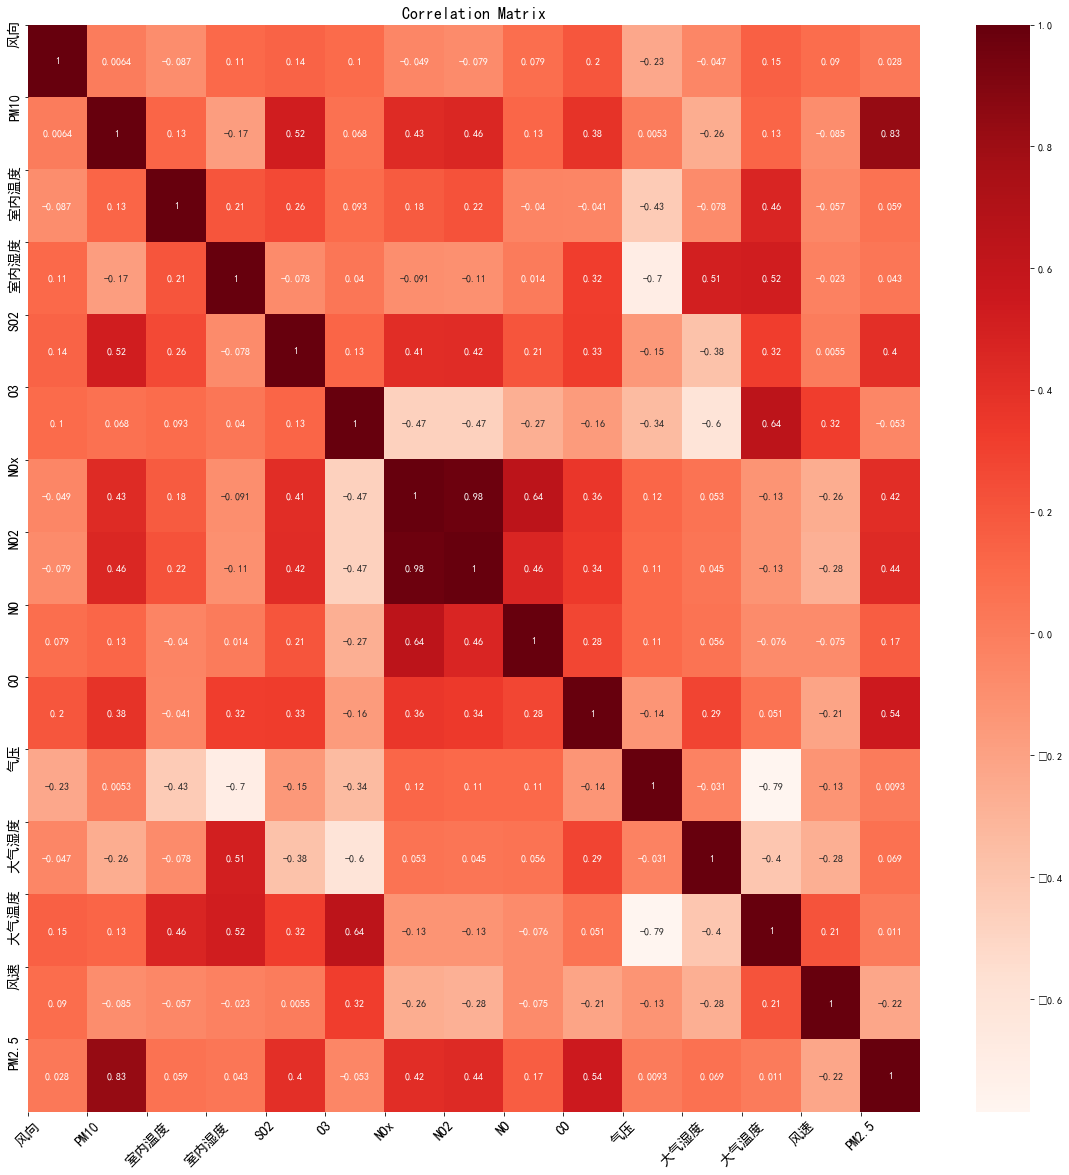

In [20]:
# multicollinearity
# can be detected by creating a correlation matrix, but we can not simply remove any variables based on the correlation matrix
# 所以在正式进行回归前，考虑通过VIF对变量进行选择

# 显示中文
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']

# correlation matrix
plt.figure(figsize=(20,20))
hm=sns.heatmap(corr_data.corr().values,annot=True,
               cmap='Reds')
plt.xticks(range(corr_data.shape[1]), corr_data.columns, fontsize=14, rotation=45)
plt.yticks(range(corr_data.shape[1]), corr_data.columns, fontsize=14)
#cb = plt.colorbar()
#cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [22]:
?variance_inflation_factor

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
# calculating VIF 
def drop_column_using_vif_(df,thresh):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)
        
        # 计算每个变量的VIF
        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        print('Max VIF:', vif_df.VIF.max())
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [23]:
# using VIF 
predictors = corr_data.drop('PM2.5',axis=1)
response = corr_data['PM2.5']

In [24]:
# threshold=5 需要drop掉的变量：NOx和大气温度
# 不同threshold得到的需要drop的变量可能不一样
df_predictors_select_VIF = drop_column_using_vif_(predictors,thresh=5)
print("The columns remaining after VIF selection are:")
print(df_predictors_select_VIF.columns)

Max VIF: 38371639.80265831
Dropping: NOx
Max VIF: 18.104338493055494
Dropping: 大气温度
Max VIF: 4.46979196500166
The columns remaining after VIF selection are:
Index(['风向', 'PM10', '室内温度', '室内湿度', 'SO2', 'O3', 'NO2', 'NO', 'CO', '气压',
       '大气湿度', '风速'],
      dtype='object')


In [25]:
# 解决了多重共线性问题后，再尝试一下linear regression
# 1. import the model
from sklearn.linear_model import LinearRegression
# 2. initialize the model
lr = LinearRegression()

In [17]:
# 不计算VIF直接对x和y进行拟合
# R2比计算过VIF的模型更高，可能是出现过拟合情况
# 3. fit the model on the training set
lr.fit(X=X_train, y=y_train)
# 4. evaluate the model performance
print('R2 for linear regression:')
lr.score(X=X_train, y=y_train)

R2 for linear regression:


0.8183913305948513

In [26]:
# 3. fit the model on the training set
lr.fit(X=df_predictors_select_VIF, y=response)
# 4. evaluate the model performance
print('R2 for linear regression:')
lr.score(X=df_predictors_select_VIF, y=response)
# 5. evaluate the performance on the test set

R2 for linear regression:


0.8121319521970447

In [27]:
# 回归方程的系数
print('Constant term: ', lr.intercept_)
df_coef_lr_VIF = pd.DataFrame({"var": df_predictors_select_VIF.columns.values, "coef":lr.coef_})
print(df_coef_lr_VIF)

Constant term:  -483.24927984894225
     var      coef
0     风向  0.005323
1   PM10  0.534972
2   室内温度 -0.236059
3   室内湿度  0.195319
4    SO2  0.232111
5     O3  0.065542
6    NO2  0.081119
7     NO  0.059562
8     CO  8.117975
9     气压  0.445401
10  大气湿度  0.270974
11    风速 -1.020066


In [28]:
# fit a lineare regression model using statsmodel
import statsmodels.api as sm
regressor_OLS = sm.OLS(endog=response, exog=sm.add_constant(df_predictors_select_VIF)).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PM2.5   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     3291.
Date:                Thu, 02 Jun 2022   Prob (F-statistic):               0.00
Time:                        15:30:25   Log-Likelihood:                -32139.
No. Observations:                9149   AIC:                         6.430e+04
Df Residuals:                    9136   BIC:                         6.440e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -483.2493     26.780    -18.045      0.000    -535.744    -430.755
风向             0.0053      0.001      4.416      0.000       0.003       0.008
PM10           0.5350      0.004    131.587      0.000       0.527       0.543
室内温度          -0.2361      0.065     -3.624      0.000      -0.364      -0.108
室内湿度           0.1953      0.018     10.687      0.000       0.159       0.231
SO2            0.2321      0.039      5.909      0.000       0.155       0.309
O3             0.0655      0.003     22.512      0.000       0.060       0.071
NO2            0.0811      0.011      7.332      0.000       0.059       0.103
NO             0.0596      0.043      1.377      0.169      -0.025       0.144
CO             8.1180      0.475     17.105      0.000       7.188       9.048
气压             0.4454      0.025     17.505      0.000       0.396       0.495
大气湿度           0.2710      0.008     32.781      0.000       0.255       0.287
风速            -1.0201      0.072    -14.195      0.000      -1.161      -0.879
==============================================================================
Omnibus:                      823.202   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1609.942
Skew:                          -0.605   Prob(JB):                         0.00
Kurtosis:                       4.661   Cond. No.                     3.26e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.26e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# 出现warning： not converge，调整max_iter保证收敛，但时间会变久很多  
# Q:max_iter代表什么，为什么变大就能保证收敛，如何判断是否收敛
# linear regression和lasso regression结果均不是特别理想，还是考虑tree-method可能会得到比较好的预测效果，放弃传统regression，继续之前想法